[GitHub Python Bar Review](https://github.com/ckorikov/python-bar-review)

# Машинное обучение в функциональном стиле

Прежде чем мы передём к основной теме, вспомним, как выглядит типовой сценарий работы с данными и моделями машинного обучения.

## 1. Типовая реализация тренировки ML 

In [1]:
import sys # пригодится

### Генерация данных

Сгенерируем синтетические данные для задачи регрессии. Для этого возьмём пакет **sklearn**.

In [2]:
from sklearn.datasets import make_regression

Подключим пакет для иллюстрация **matplotlib**.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8,6] # сделаем размер генерируемых картинок побольше

Сгненерируем данные с шумом, которые имеют линейную связь между величинами _x_ и _y_.

In [4]:
seed = 42 
x, y = make_regression(n_samples=1000, n_features=1, noise=4, random_state=seed) # 1000 точек, одномерная величина, std=4
# Приведём к стандартному типу с плавающей одинарной точности
x = x.astype('float32') 
y = y.astype('float32')
# Приведём к стандартной размерности (batch, feature), то есть (1000, 1)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

Документация по `make_regression`: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

Проиллюстрируем данные

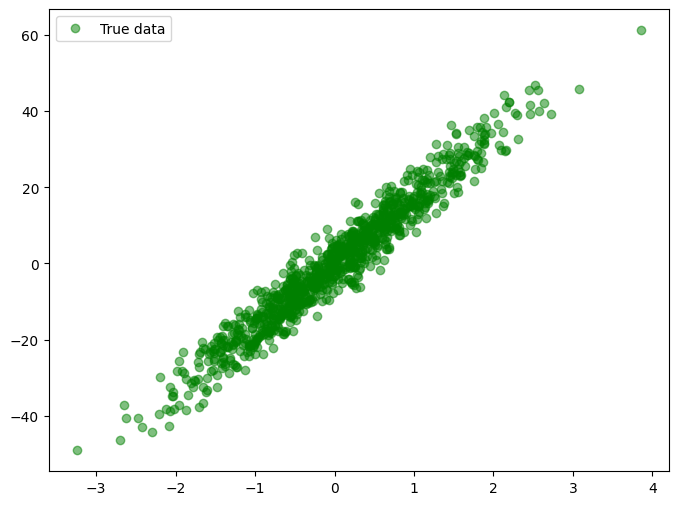

In [5]:
plt.clf()
plt.plot(x, y, 'go', label='True data', alpha=0.5)
plt.legend(loc='best')
plt.show()

### Модель ML

Построим обычную линейную регрессию, используя **pytorch**.

In [6]:
import torch
import torch.nn as nn

Линейная регрессия в матрчной форме задаётся такой формулой:
$$
y = x \cdot \textrm{weights}^T   + \textrm{bias}
$$

это уравнение прямой $y=kx+b$, где размерности матриц следующие:

$$
[n,o]  = [n,i]  \cdot  [i,o] + [o]
$$

$n$ — размер батча (у нас 1000), $o$ — размерность входного тензора (у нас 1), размерность выходного тензора (у нас 1).

In [7]:
# Размерности входов и выходов
x.shape, y.shape

((1000, 1), (1000, 1))

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self, features_in, features_hidden):
        super().__init__()
        self.linear = nn.Linear(features_in, features_hidden) # Линейный слой y=xW^T+b
    def forward(self, x):
        return self.linear(x)

Документация по `Linear`: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [9]:
model = LinearRegressionModel(1, 1)

Проверим структуру модели

In [10]:
model

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Посмотрим параметры (модель имеет состояние — параметры)

In [11]:
for name,param in model.named_parameters():
    print(f"{name}: {param.data}")

linear.weight: tensor([[0.1931]])
linear.bias: tensor([-0.4866])


### Тренировка модели

Мы можем обучать на устройстве, выберем, если есть.
- Apple: Metal Performance Shaders (MPS)
- Nvidia: Compute Unified Device Architecture (CUDA)

In [12]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Нашли

In [13]:
device

device(type='mps')

Процедура тренировки:
- Гиперпараметры: learning rate и число эпох
- Loss-функция — MSE (оптимальная loss-функция для задачи регрессии с нормальными данными в задаче MLE)
- Опимизатор — градиентый спуск
- Обучением батчами (не мини-батчами, 1 проход — весь датасет)

Цикл тренировки на каждой эпохе:
- Очищаем градиенты (тензоры хранят значения градиентов, вычисленные ранее)
- Переносим данные на устройство (если надо)
- Выполняем вычисление (forward)
- Вычисляем ошибку (loss) — тензор
- Вычисляем от ошибки градиенты (производную) для всех тензоров, которые требуют изменения (оптимизации, тренировки) методом обратного распространения ошибки (backward)
- Оптимизируем параметры, для которых высчитаны градиенты $w = w_0 + \textrm{lr} \cdot \nabla w$

In [14]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()

    inputs = torch.from_numpy(x).to(device)
    labels = torch.from_numpy(y).to(device)
    
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward() # средний градиент для всего батча
    optimizer.step()

    if epoch%10 == 0:
        print(f'epoch {epoch}, loss {loss.item()}')

epoch 0, loss 277.4445495605469
epoch 10, loss 193.32298278808594
epoch 20, loss 136.24398803710938
epoch 30, loss 97.51134490966797
epoch 40, loss 71.2261962890625
epoch 50, loss 53.38703536987305
epoch 60, loss 41.279109954833984
epoch 70, loss 33.060546875
epoch 80, loss 27.48162269592285
epoch 90, loss 23.694271087646484
epoch 100, loss 21.122989654541016
epoch 110, loss 19.377201080322266
epoch 120, loss 18.191804885864258
epoch 130, loss 17.386871337890625
epoch 140, loss 16.840253829956055
epoch 150, loss 16.469032287597656
epoch 160, loss 16.216909408569336
epoch 170, loss 16.045665740966797
epoch 180, loss 15.929347038269043
epoch 190, loss 15.850333213806152


Посчитаем, что предсказывает модель для _x_

In [15]:
with torch.no_grad(): # переключаем в режим "без градиентов"
    inputs = torch.from_numpy(x).to(device)
    predicted = model(inputs).cpu().data.numpy()

Иллюстрация

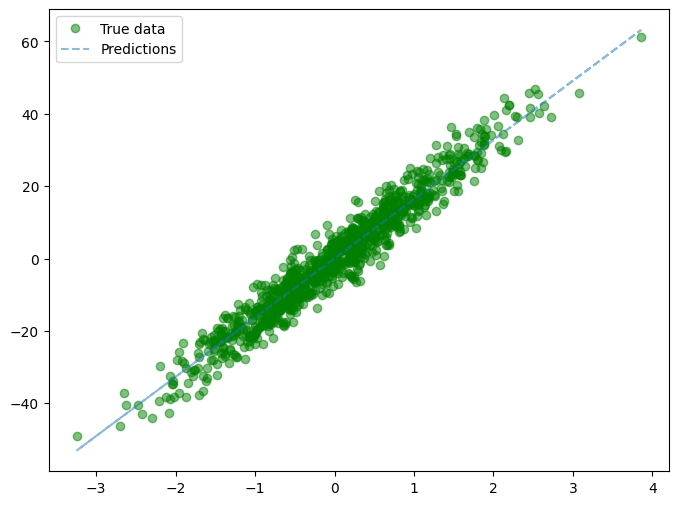

In [16]:
plt.clf()
plt.plot(x, y, 'go', label='True data', alpha=0.5)
plt.plot(x, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

## 2. Функциональное программирование

Инженерия — это про управление сложностью. В императивном программировании мы пишем команды, которые изменяют состояние программы. Это источник сложности. Когда программы разрастаются, становится ещё сложнее. Спасает ООП в основном за счёт инкапсуляции (локализация состояния и кода, который его изменяет, в одном объекте). В функциональном подходе предлагается альтернативное решение: минимизировать, а лучше вообще убрать изменение состояния программы. Поэтому, ключевое понятие функционального прогрммирования — immutability.

**Концепции в функциональном стиле (парадигме) программирования:**

- Immutability
- Pure functions (отображают вход в выход, нет побочных эффектов)
    - Referential transparency (значение ↔️ вызов функции)
    - Anonymous Functions (aka lambda)
- Higher order functions (аргументы — другие фукнкции, functions are first-class objects)
- Lazy Evaluation (not eager evaluation)
- Function composition
- Recursion (вместо циклов)

**Математика:**
- [Lambda calculus](https://en.wikipedia.org/wiki/Lambda_calculus)
- [Category theory](https://en.wikipedia.org/wiki/Category_theory)

**Паттерны:**
- Option type (None-value вместо exceptions)
- Functor (mappable containers: list)
- Monoid (identity + associativity compositon functions: +, concat)
- Monad (functor c flatmap)
- ...

### Зачем функциональное программирование в машинном обучении?

- Bug-free: concise, modular, and reusable
- Scale: parallelization
- Fun 😀

**Решает технические проблемы:**
- computing per-sample-gradients (or other per-sample quantities)
- running ensembles of models on a single machine
- efficiently batching together tasks in the inner-loop of MAML
- efficiently computing Jacobians and Hessians
- efficiently computing batched Jacobians and Hessians

# 3. Машинное обучение в функциональном стиле

Мы рассмотрим доминирующую экосистему пакета JAX и функциональное API к популярному фреймворку Pytorch.

## 3.1. JAX

Документация: https://jax.readthedocs.io/en/latest/index.html

Поддреживает разные backends: CPU, CUDA, TPU. Для поддержки Metal: https://developer.apple.com/metal/jax/

### Что такое JAX?

В области машинного обучения основные вычислительные эксперименты проводят с использованием языка программирования Python. Для работы с многомерными массивы используют библиотеку numpy. В 2018 году Google выпустила библиотеку для Python, которая стала по сути стандартным инструментом их разработок — JAX. Они создали инстурумент, который полностью повторяет API numpy, но работает на разных backendах: CPU, GPU (Nvidia), TPU (Google), MPS (Apple). Они вязли удобноство и добавили к нему скорость через jit-компиляцию (just-in-time). 

JAX — это:
- **JIT-компиляция**
- **Векториязация.** Функциональный стиль API, который упрощает векторизацию вычислений (применении функции к большим данным)
- **Дифференциальное программирование.** Возможность вычисляеть производные, что необходимо для градиентных методов оптимизации


Кто использует?

💼 Google (Google Brain, DeepMind)

### JAX API ≅ Numpy API

Код, написанный на numpy можно переиспользовать, подменив на вызов jax

In [17]:
import numpy as np
import jax.numpy as jnp

#### NumPy

Простейший пример — вычисление функции в точках

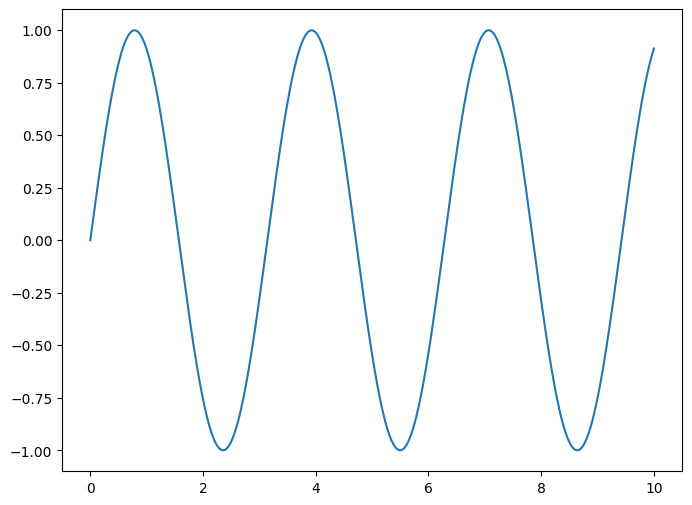

In [18]:
xv = np.linspace(0, 10, 1000)
yv = 2 * np.sin(xv) * np.cos(xv)
plt.plot(xv, yv);

In [19]:
type(xv), type(yv) # типы

(numpy.ndarray, numpy.ndarray)

#### JAX

Аналогичный пример в JAX: просто замена np -> jnp

Metal device set to: Apple M1 Pro


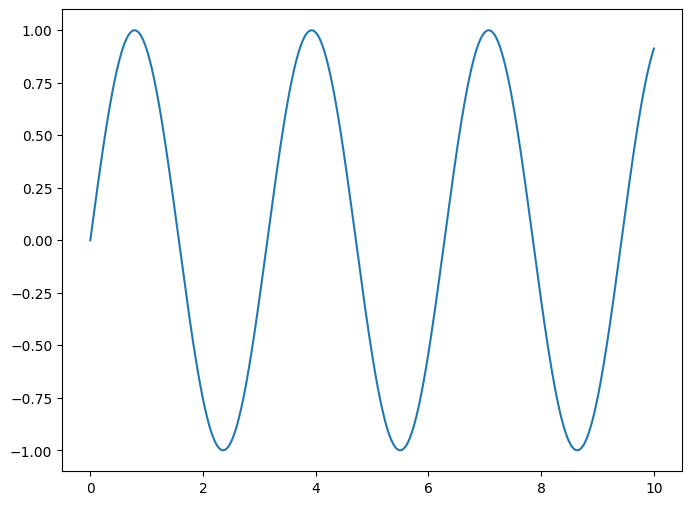

In [20]:
xv = jnp.linspace(0, 10, 1000)
yv = 2 * jnp.sin(xv) * jnp.cos(xv)
plt.plot(xv, yv);

In [21]:
type(xv), type(yv) # другие типы

(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

### ⚠️ Особенность: Immutable Arrays

В отличии от numpy в jax неизменяемые массивы

In [22]:
a = np.zeros(shape=(10, 1))
print("   до", a.T)
a[0]=1
print("после", a.T)

   до [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
после [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [23]:
try:
    a = jnp.zeros(shape=(10, 1))
    print("   до", a.T)
    a[0]=1 # должна быть ошибка
    print("после", a.T)
except Exception as e:
    print(e, file=sys.stderr)

   до [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


'<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


В парадигме jax, если надо изменить значение, то мы его копируем

In [24]:
a = jnp.zeros(shape=(10, 1))
print("   до", a.T)
b = a.at[0].set(1) # in jit is in-place
print("после", a.T)
print("после", b.T, "(копия)")

   до [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
после [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
после [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] (копия)


### Генерация случайных чисел

#### NumPy

В 2023 NumPy испольузет PCG-64 PRNG (pseudo-random number generator). Это 128-bit implementation of O’Neill’s permutation congruential generator. Раньше они использовали MT19937 (Mersenne Twister pseudo-random number generator). Legacy-подход с MT19937 проблемно распараллеливать, современный NumPy лучше адаптиврован к современным приложениям.

In [25]:
import numpy as np
rng = np.random.default_rng(seed)  # глобальное состояние

In [26]:
rng = np.random.default_rng() # стандартный генератор (PRNG)
rng

Generator(PCG64) at 0x2A2FC6500

Генератор внутри содержит `bit generator`, который является менеджером состояния PRNG

In [27]:
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 256260436683230182605273271169713760056,
  'inc': 338774105971557216365734128497730256579},
 'has_uint32': 0,
 'uinteger': 0}

Генерируем случайное число

In [28]:
rng.uniform()

0.06083900948547161

Проверим состояние

In [29]:
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 310074884335486259574497155787422310619,
  'inc': 338774105971557216365734128497730256579},
 'has_uint32': 0,
 'uinteger': 0}

NumPy предлагает решать задачу распараллеливания разными техниками:
- SeedSequence spawning
- Sequence of Integer Seeds
- Independent Streams
- Jumping the BitGenerator state

Смотрите документацию: https://numpy.org/doc/stable/reference/random/parallel.html

#### NumPy legacy

Глобальное состояние — проблема при распараллеливании кода. 

In [30]:
seed = 42
np.random.seed(seed) # глобальное состояние

Посмотрим состояние генератора

In [31]:
full_random_state = np.random.get_state()
print(str(full_random_state)[:460])

('MT19937', array([        42, 3107752595, 1895908407, 3900362577, 3030691166,
       4081230161, 2732361568, 1361238961, 3961642104,  867618704,
       2837705690, 3281374275, 3928479052, 3691474744, 3088217429,
       1769265762, 3769508895, 2731227933, 2930436685,  486258750,
       1452990090, 3321835500, 3520974945, 2343938241,  928051207,
       2811458012, 3391994544, 3688461242, 1372039449, 3706424981,
       1717012300, 1728812672, 1688496645, 120


Сгенерируем числов

In [32]:
np.random.uniform()

0.3745401188473625

Проверим как изменилось состояние

In [33]:
full_random_state = np.random.get_state()
print(str(full_random_state)[:460])

('MT19937', array([ 723970371, 1229153189, 4170412009, 2042542564, 3342822751,
       3177601514, 1210243767, 2648089330, 1412570585, 3849763494,
       2465546753, 1778048360, 3414291523, 3703604926,   37084547,
       2893685227, 1573484469, 1285239205,  699098282, 4130757601,
        396734834, 4180643673, 4141803214, 1198799333,  762411010,
        293648282, 3223568971, 2632094559,  537008479,  741113140,
       4002027498, 2746025092, 2845827535,  54


#### JAX

JAX предлает свой подход к API: обязательный ключ для всех методов генерации + менеджмент ключей. Это обсуловлено требованиями к генератору случайных чисел от JAX:
- reproducible
- parallelizable
- vectorisable

Они используют Threefry counter-based PRNG.

In [34]:
from jax import random

seed = 42
key = random.PRNGKey(seed) 

print(key)

[42 42]


Подавая один и тот же ключ в функцию генерации, мы получим одно и то же значение на выходе — reproducible 😎

In [35]:
print(random.uniform(key))
print(random.uniform(key))

0.17487848
0.17487848


Если надо новое случайное число, то мы должны получить новый ключ!

In [36]:
new_key, subkey = random.split(key)
print("new key:", new_key) # для передачи для дальнейших нужд aka propagation key
print("subkey:", subkey) # ключ для использования локально

new key: [1740183447 2549240159]
subkey: [355035417 137792341]


Генерация с новым ключом

In [37]:
print(random.uniform(new_key))

0.81399584


### JIT в JAX: backends через XLA

JIT — это Just In Time компиляция в промежуточное представление на языке `jaxpr` для эффеткивной работы с XLA.

In [38]:
from jax import jit

#### Пример с norm

Давайте объявим функцию и скомпилируем её с помощью jit-компилятора. Нормализация массива (делаем среднее 0 и дисперсию 1)

In [39]:
# Функция нормализации
def norm(x):
  x = x - x.mean(0)
  return x / x.std(0)

Сгенерируем матрицу

In [40]:
from jax import random
key = random.PRNGKey(0)
a = random.normal(key, (1000, 100))

Проверим скорость работы

In [41]:
norm(a).block_until_ready() # при первом запуске происходит инициализация
%timeit norm(a).block_until_ready()

759 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**NB:** JAX исползует **lazy-вычисления** (возвращает future, надо вызывать block_until_ready, чтобы дождаться результата)

In [42]:
from jax import jit
norm_compiled = jit(norm) # скомпилируем

Проверим скорость jit-скомпилированной версии

In [43]:
norm_compiled(a).block_until_ready() # при первом запуске происходит инициализация
%timeit norm_compiled(a).block_until_ready()

393 µs ± 8.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Сравним со скоростью на CPU:

In [44]:
norm_compiled_cpu = jit(norm, backend='cpu')
norm_compiled_cpu(a).block_until_ready() # при первом запуске происходит инициализация
%timeit norm_compiled_cpu(a).block_until_ready()

511 µs ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Как выглядит код внутри?

In [45]:
from jax import make_jaxpr
make_jaxpr(norm)(a)

{ lambda ; a:f32[1000,100]. let
    b:f32[100] = reduce_sum[axes=(0,)] a
    c:f32[100] = div b 1000.0
    d:f32[1,100] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 100)] c
    e:f32[1000,100] = sub a d
    f:f32[100] = pjit[
      jaxpr={ lambda ; g:f32[1000,100] h:i32[]. let
          i:f32[100] = pjit[
            jaxpr={ lambda ; j:f32[1000,100] k:i32[]. let
                l:f32[100] = reduce_sum[axes=(0,)] j
                m:f32[1,100] = broadcast_in_dim[
                  broadcast_dimensions=(1,)
                  shape=(1, 100)
                ] l
                n:f32[1,100] = div m 1000.0
                o:f32[1000,100] = sub j n
                p:f32[1000,100] = integer_pow[y=2] o
                q:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] k
                r:f32[] = sub 1000.0 q
                s:f32[100] = reduce_sum[axes=(0,)] p
                t:f32[100] = div s r
              in (t,


#### Как работает JIT?

Эффективный запуск выполняется в несколько шагов:
- Шаг 1. Jiting функции (на самом деле не компилирует, а помечает «под компиляцию»)
- Шаг 2. Tracing (первый запуск с аргументом) — построение `jaxpr`
    - Каждый аргумент функции оборачивается в `tracer`-объект
    - При проходе через функцию запоминается последовательность применения jax-команд к `tracer`-объектам
    - По командам строится `jaxpr` — функция с типизированными аргументами
    - Важно: side-effect операции игнорируются
    - Важно: если есть ветвление (if-else), запоминается только 1 ветка
- Шаг 3. XLA-компиляция под backend
    - Из `jaxpr` строится XLA вычислительный граф (интерфейс `JAX`-`XLA`)
    - Сложный процесс компиляции под backend:
        -  Target-independent optimizations ([Common subexpression elimination](https://en.wikipedia.org/wiki/Common_subexpression_elimination) and so on)
        -  Target-independent operation fusion
        -  Buffer analysis (memory allocation)
        -  Target-aware optimization (fusion, partitioning, operation pattern-match)
        -  LLVM-based target code generation (+ LLVM code optimization)
            -  Для GPU использу [LLVM NVPTX](https://llvm.org/docs/NVPTXUsage.html)
    - Скомпилированный код кэшируется
    - Если меняются аргументы (shape, static variables) — перекомпиляция 
- Шаг 4. Запуск скомпилироанной под backend-версии из кэша

Подроблей про XLA: https://www.tensorflow.org/xla/architecture

#### Пример с matmul

In [46]:
def matmul(x, y):
  return x@y

In [47]:
from jax import random
key = random.PRNGKey(0)
a = random.normal(key, (1024, 1024))
key, _ = random.split(key)
b = random.normal(key, (1024, 1024))

In [48]:
matmul(a,b).block_until_ready()
%timeit matmul(a,b).block_until_ready()

872 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from jax import jit
matmul_compiled = jit(matmul)

In [50]:
matmul_compiled(a,b).block_until_ready()
%timeit matmul_compiled(a,b).block_until_ready()

855 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
matmul_compiled_cpu = jit(matmul, backend='cpu')
matmul_compiled_cpu(a,b).block_until_ready()
%timeit matmul_compiled_cpu(a,b).block_until_ready()

5.12 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
from jax import make_jaxpr
make_jaxpr(matmul)(a,b)

{ lambda ; a:f32[1024,1024] b:f32[1024,1024]. let
    c:f32[1024,1024] = dot_general[dimension_numbers=(([1], [0]), ([], []))] a b
  in (c,) }

### Векторизация и распаралливание на несколько устройств

Неявное распараллеливание через XLA

Напишем функцию для 1 sample (свёртка)

In [53]:
def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

Пример работы функции

In [54]:
v = jnp.arange(5)
w = jnp.array([2., 3., 4.])
convolve(v,w)

Array([11., 20., 29.], dtype=float32)

Мы можем запустить эту функцию для батча через векторизацию

In [55]:
from jax import vmap

# Строим батчи
vs = jnp.stack([v, v]) 
ws = jnp.stack([w, w])

auto_batch_convolve = vmap(convolve) # векторизация
auto_batch_convolve(vs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

Можно настроить in_axes, out_axes, чтобы веткоризовать по нужной размерности 

#### VMAP -> PMAP

При использовании нескольких ускорителей, можно легко распараллелить явно код между ними

In [56]:
from jax import pmap, local_device_count,devices

На этой машине доспуны устройства 

In [57]:
devices()

[MetalDevice(id=0, process_index=0)]

Если устройств больше 1, то можно вызвать pmap

In [58]:
auto_batch_convolve = pmap(convolve)

if local_device_count()  >  1:
    auto_batch_convolve(vs, ws) 

### Дифференцирование

В отличие от других библиотек дифференцирование применяется к функции, а не к массиву (тензору)

In [59]:
from jax import grad

#### Склярные функции одного аргумента

Скалярная функция скалярного аргумента

In [60]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

Первая производная

In [61]:
# 3x**2 + 4x - 3
dfdx = grad(f)

In [62]:
xscal = jnp.array(1.)
f(xscal), dfdx(xscal)

(Array(1., dtype=float32, weak_type=True),
 Array(4., dtype=float32, weak_type=True))

Вторая производная

In [63]:
# 6x+4
dfdxdx = grad(dfdx)
dfdxdx(xscal)

Array(10., dtype=float32, weak_type=True)

#### Склярные функции нескольких аргумента

- Первая производная — вектор
- Вторая производная — матрица (Hessian)

In [64]:
from jax import jacfwd, jacrev
xvec = jnp.array([1.0,2.0,3.0])
f = lambda x: jnp.dot(x, x)

Значение аргумента и функции

In [65]:
xvec, f(xvec)

(Array([1., 2., 3.], dtype=float32), Array(14., dtype=float32))

Вычисление градиента

In [66]:
grad(f)(xvec)

Array([2., 4., 6.], dtype=float32)

Вычисление Гессиана (матрицы вторых частных производных) сложнее

In [67]:
try:
    grad(grad(f))(xvec) # должна быть ошибка
except Exception as e:
    print(e, file=sys.stderr)

Gradient only defined for scalar-output functions. Output had shape: (3,).


В JAX используются 2 функции из autograd:
- `jacfwd` — прямой проход
- `jacrev` — обратный проход

In [68]:
hessian = jit(jacfwd(jacrev(f)))

In [69]:
hessian(xvec)

Array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

### Экосистема 

JAX обладает разнообразной архитектурой, ниже приведены некоторые примеры пакетов, базирующиеся на JAX
- Flax: Google, пакет для моделирования нейронных сетей, https://flax.readthedocs.io/en/latest/getting_started.html
- Haiku: DeepMind, пакет для моделирования нейронных сейтей, https://dm-haiku.readthedocs.io/en/latest/
- Eqinox: Patrick Kidger, Google X, пакет для моделирования нейронных сейтей, https://docs.kidger.site/equinox/
- Optax: DeepMind, пакет градиентных оптимизационных методов, https://optax.readthedocs.io/en/latest/
- RLax: DeepMind, пакет для reinforcement learning'а, https://rlax.readthedocs.io/en/latest/
- Chex: DeepMind, пакет для тестирования, https://chex.readthedocs.io/en/latest/
- Jraph: DeepMind, пакет для графовых нейронных сейтей, https://jraph.readthedocs.io/en/latest/

#### Flax

Документация: https://flax.readthedocs.io/en/latest/getting_started.html

GPT2 Flax in transformers: https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_flax_gpt2.py#L380

## 3.2. Pytorch Func (ex-functorch)

JAX-like API библиотека

Документация: https://pytorch.org/docs/stable/func.html

#### Основные элементы API

- `grad(f)` gradient computation
- `vmap(f)` auto-vectorization

In [70]:
import torch

In [71]:
model = LinearRegressionModel(1,1)
model

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [72]:
params = dict(model.named_parameters())
params

{'linear.weight': Parameter containing:
 tensor([[0.8830]], requires_grad=True),
 'linear.bias': Parameter containing:
 tensor([-0.0017], requires_grad=True)}

In [73]:
from torch.func import functional_call
inputs = torch.from_numpy(x)
out = functional_call(model, params, (inputs,))

In [74]:
from torch.func import grad
grad_fn = grad(model) # возвращает функцию, преобразующую model (как функцию), аргументы те же

### Per-sample gradients 

#### Традиционный подход

In [75]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 

def compute_grad(sample, target):
    sample = sample.unsqueeze(0) 
    target = target.unsqueeze(0)

    prediction = model(sample)
    loss = criterion(prediction, target)

    return torch.autograd.grad(loss, list(model.parameters()))


def compute_sample_grads(data, targets):
    batch_size = data.shape[0]
    sample_grads = [compute_grad(data[i], targets[i]) for i in range(batch_size)]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads


In [76]:
inputs = torch.from_numpy(x).to(device)
labels = torch.from_numpy(y).to(device)
per_sample_grads = compute_sample_grads(inputs, labels)

In [77]:
len(per_sample_grads)

2

In [78]:
per_sample_grads[0].shape # weight

torch.Size([1000, 1, 1])

In [79]:
per_sample_grads[1].shape # bias

torch.Size([1000, 1])

#### Функциональный подход

In [80]:
from torch.func import functional_call, vmap, grad

In [81]:
lr = 0.01 
epochs = 200

model = model.to(device)
model = model.train()

criterion = torch.nn.MSELoss() 

params = {k: v.detach() for k, v in model.named_parameters()}


def compute_loss(params, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)

    predictions = functional_call(model, (params,), (batch,))
    loss = criterion(predictions, targets)
    return loss


ft_compute_grad = grad(compute_loss)

ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, 0, 0))

In [82]:
inputs = torch.from_numpy(x).to(device)
labels = torch.from_numpy(y).to(device)
ft_per_sample_grads = ft_compute_sample_grad(params, inputs, labels)

In [83]:
ft_per_sample_grads['linear.weight'].shape

torch.Size([1000, 1, 1])

In [84]:
for per_sample_grad, ft_per_sample_grad in zip(per_sample_grads, ft_per_sample_grads.values()):
    assert torch.allclose(per_sample_grad, ft_per_sample_grad, atol=3e-3, rtol=1e-5)

#### Сравнение производительности

In [85]:
%timeit compute_sample_grads(inputs, labels)

325 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit ft_compute_sample_grad(params, inputs, labels)

753 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Почитать

In [87]:
%load_ext watermark
%watermark -d -u -v -iv

Last updated: 2023-07-12

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
numpy     : 1.25.1
sys       : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
jax       : 0.4.11
torch     : 2.0.1

